# Quick PRF photometry using TESS data

This is quick tutorial that shows how `lightkurve` can be used to build
PRF photometry light curves using data from the TESS mission.

WARNING: The PRF model used here is **heuristically** constructed on the basis of the PRF calibrated
files released by the TESS science team at https://archive.stsci.edu/missions/tess/models/.

Let's start by performing the usual imports of numpy, matplotlib, and `lightkurve`:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import TessTargetPixelFile, TessLightCurveFile

Now, we get the target pixel file of TIC 25155310 directly from the URL available at MAST:

In [3]:
tpf = TessTargetPixelFile("https://archive.stsci.edu/hlsps/tess-data-alerts/"
                          "hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_tp.fits")

Let's take a quick look at the pixel data:

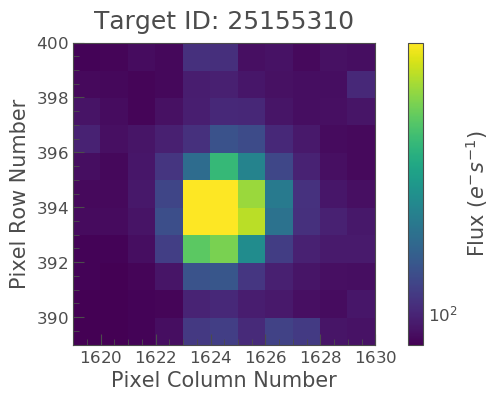

In [4]:
tpf.plot(bkg=True, scale='log')

And also the tpf model:

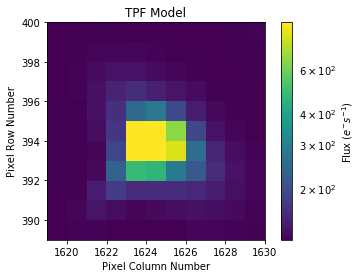

In [5]:
tpf.get_model().plot(scale='log')

Now let's estimate the light curve yielded by this model, after fitted to the pixel data, using the method `to_lightcurve`: 

In [ ]:
prf_lc = tpf.to_lightcurve(method='prf')

Fitting cadences:  72%|███████▏  | 13020/18104 [10:50<04:13, 20.03it/s]

In [ ]:
prf_lc.plot()

The process turns out OK, and we can clearly see 4-day-ish periodic transits.

To make the light curve cleaner, we remove the long term variation using the method `flatten`:

In [ ]:
flat_lc, trend_lc = prf_lc.flatten(window_length = 1001, return_trend=True, break_tolerance=1000)
ax = trend_lc.plot()
prf_lc.plot(ax=ax, alpha = .5)

In [ ]:
flat_lc.plot()

Next, we compare the PRF light curve with the PDCSAP lightcurve, which is made available by the TESS official pipeline:

In [ ]:
lc_pipe = TessLightCurveFile("https://archive.stsci.edu/hlsps/tess-data-alerts/"
                             "hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_lc.fits")

In [ ]:
pdc_lc = lc_pipe.PDCSAP_FLUX
pdc_lc.flux = pdc_lc.flux / np.nanmedian(pdc_lc.flux)

In [ ]:
ax = pdc_lc.plot(alpha=.5, color='red', label='PDCSAP_FLUX')
flat_lc.plot(ax=ax, alpha=.5, color='blue', label='PRF_FLUX')

As we can observe the PRF light curve is comparable to the PDCSAP light curve as far as the first half of
the observation is considered. On the second half, the model is a bit off and further investigation is required.

Now, rather than using the PRF model built from calibrated data, let's consider a simple two-dimensional Gaussian
as the PRF model.

In [ ]:
from lightkurve.prf import GaussianPRF

In [ ]:
prfphot = tpf.extract_prf_photometry(prfmodel=GaussianPRF(shape=tpf.shape[1:], column=tpf.column, row=tpf.row),
                                     fit_focus=True)

In [ ]:
gauss_prf_lc = prfphot.lightcurves[0]